In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.datasets import make_blobs
import random
import json
import time
from tabulate import tabulate
from sklearn.datasets import load_iris
from sklearn.mixture import GaussianMixture

from kdtree import *
from utils import *

In [2]:
savefile = "data.json"
points_count = 100
to_plot = True

In [3]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Initialize the parameters
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Initialize the parameters
noise = 0.05  # Amount of noise

# Generate the data
X, y = make_circles(n_samples=points_count, noise=noise, factor=0.5, random_state=42)

# Convert the data to a list of tuples
points = [(x, y) for x, y in X]
# points = [(round(x , 1), round(y , 1)) for x, y in X]
maxdis = math.ceil(math.log2(points_count))

In [4]:
X, Y = make_blobs(n_samples=points_count, centers=4, random_state=42)
points = [(x, y) for x, y in X]

In [5]:
def build():
    tree = KDTree()
    tree.root = tree.build(points)

    G = nx.Graph()

    for point in points:
        G.add_node(point , pos = point)

    neighbours = {}
    maxdis = math.ceil(math.log2(points_count))
    for point in points:
        neighbours[point] = i_neighbors(tree, point, maxdis)
    return  G,  neighbours
    

In [6]:
def merge_comps(core1 , core2, core_points_map , mst):
    pivot2 = min(core_points_map[core2], key=lambda node: euclidean_distance(node, core1))
    pivot1 = min(core_points_map[core1], key=lambda node: euclidean_distance(node, pivot2))
    mst.add_edge(pivot1, pivot2 , weight = euclidean_distance(pivot1, pivot2))
    print(f"merging {core1} and {core2} with pivot {pivot1} and {pivot2}")

In [7]:
def merge_phase(G):
    core_points_map = {}
    for component in nx.connected_components(G):
        centroid = np.mean([node for node in component], axis=0)
        closest_point = min(component, key=lambda node: euclidean_distance(node, centroid))
        core_points_map[closest_point] = component

    core_points = list(core_points_map.keys())

    minc = [float("inf")] * len(core_points[0])
    maxc = [float("-inf")] * len(core_points[0])

    for point in core_points:
        for i in range(len(point)):
            minc[i] = min(minc[i], point[i])
            maxc[i] = max(maxc[i], point[i])

    diff = [maxc[i] - minc[i] for i in range(len(minc))]
    min_diff_axis = diff.index(max(diff))

    sorted_core_points = sorted(core_points, key=lambda point: point[min_diff_axis])
    for core1 , core2 in zip(sorted_core_points, sorted_core_points[1:]):
        merge_comps(core1, core2, core_points_map, G)
        
    
    

In [8]:
def dcrun():
    G,   neighbours = build()
    print(G.number_of_nodes() , G.number_of_edges())
    k = 0
    while ( k   < maxdis) :
        print("Connected Components : " , len(list(nx.connected_components(G))))
        print(
            f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges."
        )
        graphify(
            G,
            to_plot,
            bottom_text=f"Iteration: {k}, Connected Components: {len(list(nx.connected_components(G)))}\nNumber of Edges: {G.number_of_edges()}",
        )
        if(len(connected_components := list(nx.connected_components(G)))) == 1 : break
        for component in connected_components:
            for node in component:
                wt , pos = neighbours[node][k]
                if pos in component : continue
                G.add_edge(node , pos , weight = wt)
        k += 1
    else :
        print("merge phase")
        merge_phase(G)
        print(
            f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges."
        )
        print("Connected Components : " , len(list(nx.connected_components(G))))
        graphify(
            G,
            to_plot,
            bottom_text=f"Merge Phase, Connected Components: {len(list(nx.connected_components(G)))}\nNumber of Edges: {G.number_of_edges()}",
        )
    mst = nx.minimum_spanning_tree(G)    
    print(mst.number_of_nodes() , mst.number_of_edges())
    mst_weight = round(sum(data["weight"] for u, v, data in mst.edges(data=True)) , 2)
    print(
        f"Minimum Spanning Tree: {mst.number_of_nodes()} nodes, {mst.number_of_edges()} edges, Total Weight: {mst_weight}"
    )

    graphify(
        mst,
        to_plot,
        bottom_text=f"Minimum Spanning Tree: {G.number_of_nodes()} nodes, \nTotal Weight: {mst_weight}",
    )

100 0
Connected Components :  100
The graph has 100 nodes and 0 edges.


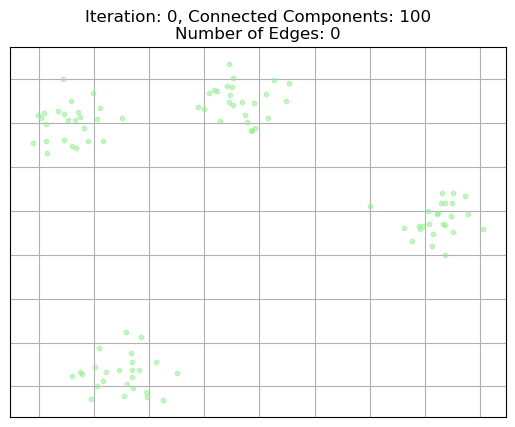

Connected Components :  25
The graph has 100 nodes and 75 edges.


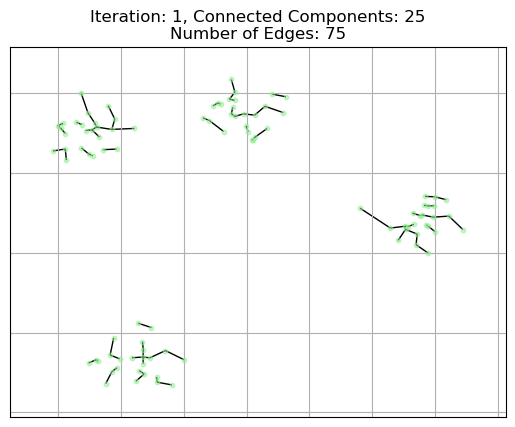

Connected Components :  4
The graph has 100 nodes and 103 edges.


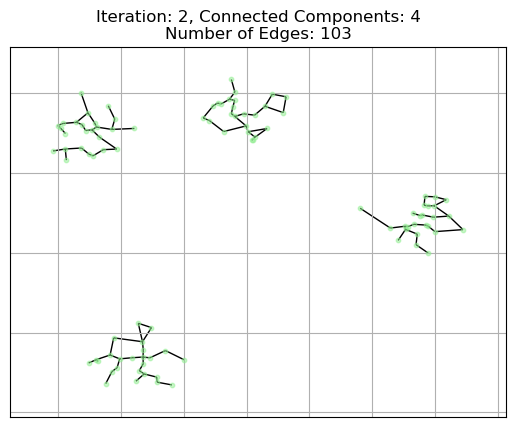

Connected Components :  4
The graph has 100 nodes and 103 edges.


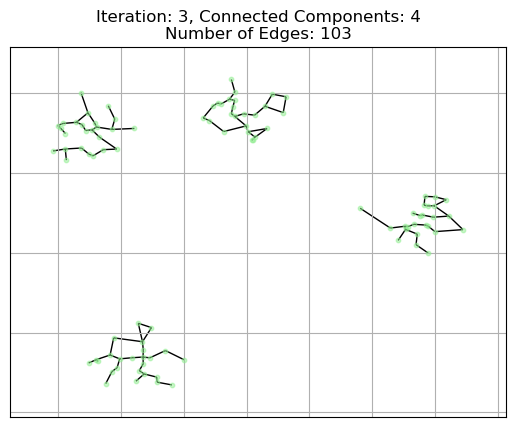

Connected Components :  4
The graph has 100 nodes and 103 edges.


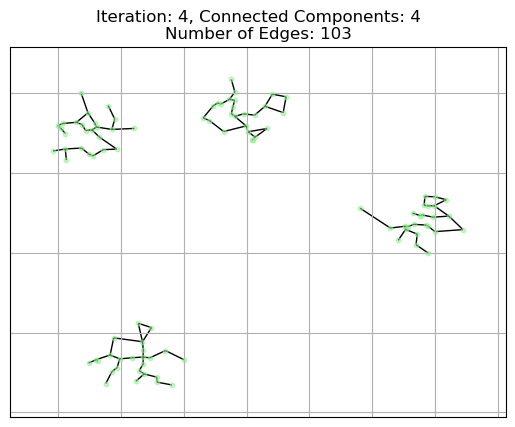

Connected Components :  4
The graph has 100 nodes and 103 edges.


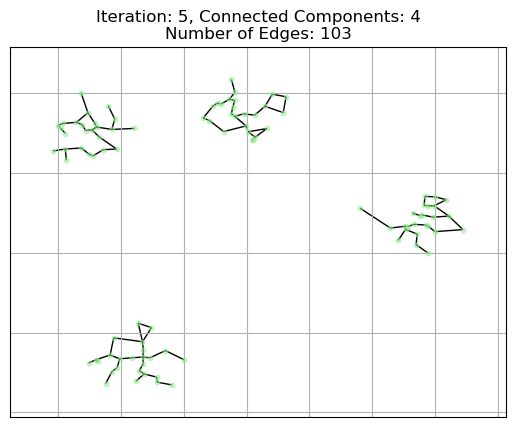

Connected Components :  4
The graph has 100 nodes and 103 edges.


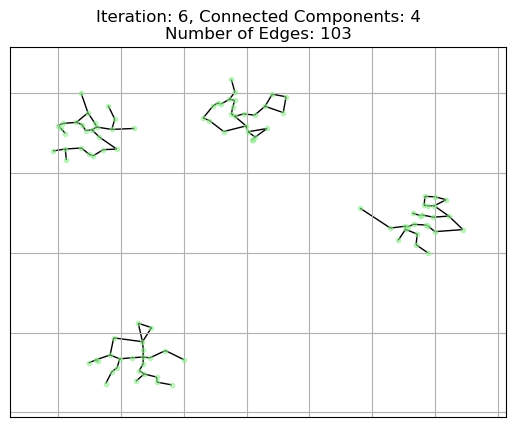

merge phase
merging (-7.0719881559323925, -6.578562250942334) and (4.4202069483905895, 2.3302822554524782) with pivot (-6.292770097351, -4.6896539674659685) and (3.533543862222073, 0.7769630598600612)
merging (4.4202069483905895, 2.3302822554524782) and (-8.915429466050114, 7.664674890315347) with pivot (2.020133732138357, 2.795072188315956) and (-6.9725532454912535, 7.797355836410491)
merging (-8.915429466050114, 7.664674890315347) and (-2.6248459054409907, 8.713182432609033) with pivot (-6.9725532454912535, 7.797355836410491) and (-4.234115455565783, 8.45199859895735)
The graph has 100 nodes and 106 edges.
Connected Components :  1


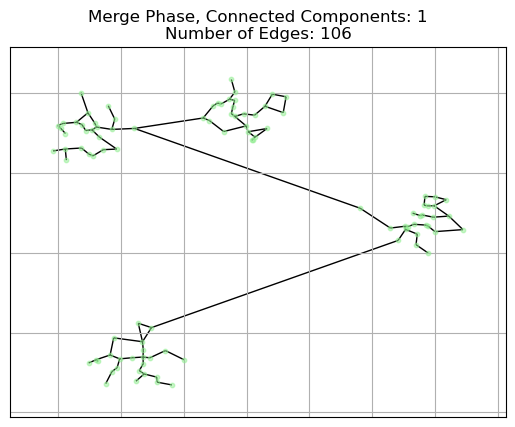

100 99
Minimum Spanning Tree: 100 nodes, 99 edges, Total Weight: 75.14


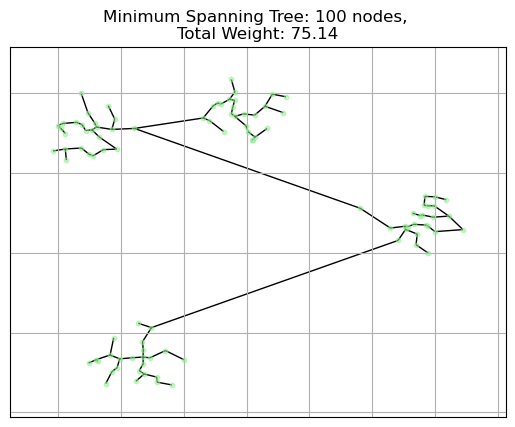

In [9]:
dcrun()

In [10]:
if (-10.215997124593102, 6.38569787558358) in points : print("yes")

yes


In [11]:
Gst = nx.Graph()

for pointi in points:
    Gst.add_node(pointi, pos=pointi)
    
for pointi in points:    
    for pointj in points:
        if pointi != pointj:
            dis = euclidean_distance(pointi, pointj)
            Gst.add_edge(pointi , pointj , weight=dis)

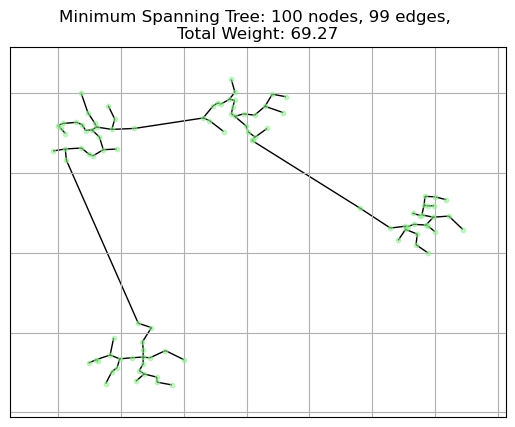

In [12]:
Gst = nx.minimum_spanning_tree(Gst, algorithm="prim", weight="weight")
mst_weight = round(sum(data["weight"] for u, v, data in Gst.edges(data=True)), 2)
graphify(
    Gst,
    to_plot,
    bottom_text=f"Minimum Spanning Tree: {Gst.number_of_nodes()} nodes, {Gst.number_of_edges()} edges, \nTotal Weight: {mst_weight}",
)